In [708]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime

In [709]:
filename = 'AAPL.csv' #pick stock
ticker = filename.split('.')[0] #get ticker
df = pd.read_csv('./data_clean/' + filename, index_col=0, sep=',') #load in data

In [710]:
#turn index col (string) into date col

def date_parse(s): #date strings are in form '2015-01-01'
    d = s.split('-')
    return datetime.date(int(d[0]), int(d[1]), int(d[2]))

df.index = df.index.map(date_parse)

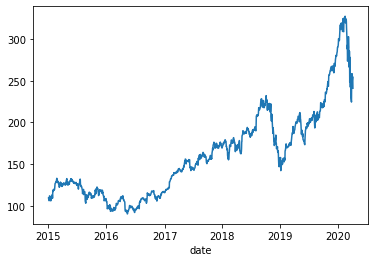

In [711]:
# Find local peaks
df['min'] = df.close[(df.close.shift(1) > df.close) & (df.close.shift(-1) > df.close)]
df['max'] = df.close[(df.close.shift(1) < df.close) & (df.close.shift(-1) < df.close)]

#print(df)

# Plot results
#plt.scatter(df.index, df['min'], c='r')
#plt.scatter(df.index, df['max'], c='g')
df.close.plot()

In [712]:
#get categorical columns for closing price and trading volume

def price_categorize(col): #start with price. don't replace price values with categories because they're needed to calculate reward/profit
    
    new_col = np.empty(len(col), dtype="<U4")
    for i in range(len(col)):
        if i == 0 or col[i] == col[i-1]:
            new_col[i] = 'same'
            
        elif col[i] < col[i-1]:
            new_col[i] = 'down'
            
        else:
            new_col[i] = 'up'
            
    return new_col

price_config = 'close' #use close to determine price
price_movements = price_categorize(df[price_config])

#get categorical volume column
quantiles = (df.volume.quantile(1/3), df.volume.quantile(2/3))

tri = [0] * len(df)

for i in range(len(df['volume'])): #replace volume counts with categories
    if df['volume'][i] <= quantiles[0]:
        tri[i] = 'low'
    elif df['volume'][i] <= quantiles[1]:
        tri[i] = 'med'
    else:
        tri[i] = 'high'

df = df.assign(volume=tri)

In [713]:
def buy(stock_df, portfolio, date, capital, num_contracts=1): 
    
    transaction_cost = stock_df.at[date, price_config] * (num_contracts * 100)
    
    if capital < transaction_cost:
        return False #can't buy if you lack the funds
    
    current_holdings = portfolio[ticker]
        
    return {ticker: current_holdings+num_contracts}, -transaction_cost #approve transaction, return updated one-stock portfolio and profit/loss (-1 * transaction_cost)
    
    
def sell(stock_df, portfolio, date, num_contracts=1):  #capital is irrelevant for selling (you can sell with any amount of capital, as long as you have enough shares)
    
    if not portfolio[ticker] or num_contracts > portfolio[ticker]:
        return False #can't sell shares you don't own
    
    gain = stock_df.at[date, price_config] * (num_contracts * 100) 
    
    current_holdings = portfolio[ticker]
    
    return {ticker: current_holdings-num_contracts}, gain #approve transaction, return updated one-stock portfolio and gain

In [714]:
def max_profit(df, ticker, capital, num_contracts=1):
    portfolio = {ticker: 0}
    extrema = df.dropna(thresh=len(df.columns)-1) #drop row if min and max both nan #how='all', subset=['min', 'max'])
    
    for trading_day in df.index.values:
        
        #print(capital, portfolio)
        
        if not pd.isnull(df.at[trading_day, 'min']): #not nan on min col: it's a local min
            b = buy(df, portfolio, trading_day, capital)
            portfolio = b[0]
            capital += b[1]
            
        elif not pd.isnull(df.at[trading_day, 'max']):
            s = sell(df, portfolio, trading_day)
            portfolio = s[0]
            capital += s[1]
            
    return capital, portfolio

mx_prof = max_profit(df, ticker, bank)
print('max final portfolio value:', mx_prof[0])
    

max final portfolio value: 221750.99639892578


In [715]:
import itertools

trend_features = ('up', 'down', 'same')
vol_features = ('low', 'med', 'high')

state_features = ( trend_features, vol_features ) #will expand over time
states = list(itertools.product(*state_features))

print(states) #all combinations of one element from each state feature tuple
#list(itertools.product(*[ ('up', 'down', 'same'), ('low', 'med', 'high'), ('good', 'ok', 'bad'), ('nay', 'kay', 'yay') ]))

[('up', 'low'), ('up', 'med'), ('up', 'high'), ('down', 'low'), ('down', 'med'), ('down', 'high'), ('same', 'low'), ('same', 'med'), ('same', 'high')]


In [737]:
import random
def arg_max(row): #pandas idxmax returns the first index of the max value in case of a tie; we want a random index instead
    maxes = row[row == row.max()]
    return random.choice(maxes.index)
    

actions = ('buy', 'sell', 'hold')

num_portfolios = 1

initial_trend = price_movements[0]
initial_vol = df.at[df.index[0], 'volume']
initial_state = (initial_trend, initial_vol)

bank = 100000 #set initial investor capital
portfolio = {ticker: 0} #initialize empty portfolio
num_contracts = 1

training_set = df[df.index < datetime.date(2019, 1, 1)]
test_set = df[df.index >= datetime.date(2019, 1, 1)]

def q_learn(df, ticker, bank, risk_tolerance, alpha, decay_rate, gamma):
    
    #initialize
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    portfolio = {ticker: 0}
    i = 0
    
    initial_trend = price_movements[i]
    initial_vol = df.at[df.index[i], 'volume']
    initial_state = (initial_trend, initial_vol)
    
    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing
        
        s = initial_state
        
        while bank > 0 and i < len(df)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            e = decay_rate ** i #decayed-epsilon-greedy method, inspired by https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp%2C_T._1.pdf?sequence=1
            
            current_date = df.index[i]
            current_price = df.at[current_date, price_config]
            next_date = df.index[i+1]
            next_price = df.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(df, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            
            #factor in epsilon
            if random.random() < e:
                a = random.choice(possible_actions)
            
            else:
                a = arg_max(q.loc[s][possible_actions])
                
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                reward = (next_price - current_price) * num_contracts * 100 #reward should be profit from next day. if you buy and the price went up, you get a positive reward
            
            if a == 'hold':
                reward = -risk_tolerance #user-specified penalty on holding
            
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #update number of shares held
                bank += short[1] #update account
                reward = (current_price - next_price) * num_contracts * 100 #reward should be profit from next day. if you sell and the price goes down, you get a positive reward
            
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            
            
            #list out what actions you can take on the next trading day
            
            possible_actions = ['hold']
            
            long = buy(df, portfolio, next_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, next_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            s_next = (trend, vol)
            q_next = q.at[s_next, arg_max(q.loc[s_next][possible_actions])]
            
            q_inc = alpha * ( reward + gamma * q_next - q.at[s, a])
            q.at[s, a] += q_inc
            
            s = s_next
            i += 1
    
    bank += next_price * portfolio[ticker] * 100
    #print( {'risk level': risk_tolerance, 'alpha': alpha, 'balance': bank } )
    
    return bank, portfolio, q
                    

In [738]:
#function to decay weight, y: 5 ** (-i/150)
#train = q_learn(training_set, ticker, bank, 25)

In [739]:
#print (train[0], train[1], '\n\n', train[2]) #learned q values

In [719]:
test_trends = price_movements[len(training_set):]

initial_trend = test_trends[0]
initial_vol = test_set.at[test_set.index[0], 'volume']
initial_state = (initial_trend, initial_vol)

def q_test(test_data, ticker, bank, q):
    
    #initialize
    portfolio = {ticker: 0}
    i = 0
    
    action_list = []
    
    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing
        
        s = initial_state
        
        #for testing

        while bank > 0 and i < len(test_data)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            current_date = test_data.index[i]
            current_price = test_data.at[current_date, price_config]
            next_date = test_data.index[i+1]
            next_price = test_data.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(df, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
                 
            a = arg_max(q.loc[s][possible_actions])
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #wqa_P;0dupdate number of shares held
                bank += short[1] #update account
            
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            s = (trend, vol) #get next state
            
            i += 1
    
    bank += next_price * portfolio[ticker] * 100
    
    return bank, portfolio
                    

In [720]:
#test_run = q_test(test_set, ticker, bank, train[2])
#print(test_run)

In [721]:
'''profits = []

for i in range(100):
    train_vals = q_learn(training_set, ticker, bank, i)
    test_run = q_test(test_set, ticker, bank, train_vals[2])
    ret_dict = {'profit': test_run[0] - bank, 'shares_held': test_run[1][ticker] * 100}
    profits.append( {i: ret_dict} )'''

"profits = []\n\nfor i in range(100):\n    train_vals = q_learn(training_set, ticker, bank, i)\n    test_run = q_test(test_set, ticker, bank, train_vals[2])\n    ret_dict = {'profit': test_run[0] - bank, 'shares_held': test_run[1][ticker] * 100}\n    profits.append( {i: ret_dict} )"

In [722]:
#print(profits)

In [723]:
#cross-validation

#helper for s_fold: creates the folds
def s_partition(s, data): 
    
    fold_size = math.ceil( len(data) / s ) #take the ceiling so no elements are missed in the case of an uneven split
    
    folded_data = [] #store folds in a list
    
    i = 0
    while i < len(data):
        
        #append the folds, incrementing by the size of each fold
        folded_data.append(data[i:i+fold_size]) 
        
        i += fold_size
        
    return folded_data

#q_learn(df, ticker, bank, risk_tolerance, alpha=0.01, e=1, y=1):
#return bank, portfolio, q

def s_fold(folds, data, model, model_args):
    
    folded_data = s_partition(folds, data)
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    
    for data_fold_index in range(folds):
        
        #exclude current fold, use other folds as training data
        training_data = folded_data[:data_fold_index] + folded_data[data_fold_index+1:] #3d array: each element is a 2d data fold
        training_data = pd.concat(training_data) #combine the 3d array into one single 2d data array to use as the feature input
        
        learner = model(training_data, **model_args) #fit model to other partitions
        
        q += learner[2]
        
    q /= folds #get "average" q values    
    return q

In [724]:
#k = 10
#risk_tolerance = 10

#cross_q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 'risk_tolerance': risk_tolerance})

In [725]:
#cross_q

In [726]:
#q_test(test_data, ticker, bank, q)

#test_run = q_test(test_set, ticker, bank, cross_q)
#print(test_run)

In [740]:
#hyperparameter tuning

learning_rates = (0.001, 0.01, 0.1)
#risk_levels = (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
risk_levels = (0, 25, 50, 75, 100)
epsilons = (0.9, 0.99, 0.999)
gammas = (0.0, 0.25, 0.5, 0.75, 1)

k = 10
max_bank = -1

runs = []

for risk_level in risk_levels: #test risk levels in increments of 10
    for learning_rate in learning_rates:
        for epsilon in epsilons:
            for gamma in gammas:
                
                cross_q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 
                        'risk_tolerance': risk_level, 'alpha': learning_rate, 'decay_rate': epsilon, 'gamma': gamma})
                test_run = q_test(test_set, ticker, bank, cross_q)

                if test_run[0] > max_bank:
                    best_params = {'balance': test_run[0], 'risk level': risk_level, 'alpha': learning_rate,
                                  'epsilon': epsilon, 'gamma': gamma}
                    max_bank = test_run[0]
                
                runs.append( {'balance': test_run[0], 'risk level': risk_level, 'alpha': learning_rate,
                                  'epsilon': epsilon, 'gamma': gamma} )
            
print('optimal parameters:', best_params)            
print(cross_q)

#next step: tune with epsilon and gamma

{'balance': 152409.00421142578, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 154834.00421142578, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 153859.00421142578, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.5}
{'balance': 155520.00427246094, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.75}
{'balance': 131063.00354003909, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 1}
{'balance': 143998.9990234375, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 131063.00354003909, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 154749.00360107422, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.5}
{'balance': 105979.99725341797, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.75}
{'balance': 153859.00421142578, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 1}
{'balance': 154141.00341796875, 'risk level': 

{'balance': 99049.99237060545, 'risk level': 25, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.5}
{'balance': 104179.99267578125, 'risk level': 25, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.75}
{'balance': 111858.98895263675, 'risk level': 25, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 1}
{'balance': 128141.99523925781, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 120396.99401855472, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 149406.99310302734, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.5}
{'balance': 127366.99066162112, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.75}
{'balance': 128141.99523925781, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 1}
{'balance': 128141.99523925781, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 148317.9946899414, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 143964.9932861328, 'risk lev

{'balance': 131039.98870849608, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 0.75}
{'balance': 110651.99737548828, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 1}
{'balance': 104373.0010986328, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 113545.99914550778, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 137513.99078369138, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.5}
{'balance': 113545.99914550778, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.75}
{'balance': 111398.98223876953, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 1}
{'balance': 127366.99066162112, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 155694.00024414065, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 128141.99523925781, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.5}
{'balance': 128141.99523925781, 'risk le

In [750]:
q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 
                        'risk_tolerance': best_params['risk level'], 
                        'alpha': best_params['alpha'], 'decay_rate': best_params['epsilon'], 'gamma': best_params['gamma']})
test_run = q_test(test_set, ticker, bank, q)
output = {'balance': test_run[0], 'risk level': best_params['risk level'], 'alpha': best_params['alpha'],
                                  'epsilon': best_params['epsilon'], 'gamma': best_params['gamma']}
print(output)

{'balance': 149613.9923095703, 'risk level': 50, 'alpha': 0.1, 'epsilon': 0.9, 'gamma': 0.0}
